In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/641.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/173.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/815.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/491.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/718.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/709.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/379.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/780.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/248.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/94.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/480.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/236.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/771.png
/kaggle/input/image-super-resolution/dataset/Raw Data/low_res/675.png
/kaggle/input/image-s

# Import Libraries

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import cv2
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.utils import plot_model, img_to_array

from IPython import display
from PIL import Image

# Load Data

In [3]:
high_res_train_images_path = "/kaggle/input/quality7/high_res/"
low_res_train_images_path = "/kaggle/input/quality7/low_res"

In [4]:
high_res_test_images_path = "/kaggle/input/quality7/high_res/"
low_res_test_images_path = "/kaggle/input/quality7/low_res"

In [5]:
SIZE = 256

In [6]:
def load_images(path, size=224, count=None):
    if count == None:
        files = os.listdir(path)
    else:
        files = os.listdir(path)[:count]
    images = []

    for file in tqdm.tqdm(files):
        img_path = os.path.join(path, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (size, size))
        img = img.astype("float32") / 255.
        img = img_to_array(img)
        images.append(img)

    images = np.array(images)
    return images

In [7]:
train_low_images = load_images(low_res_train_images_path, size=SIZE)

100%|██████████| 189/189 [00:01<00:00, 120.34it/s]


In [8]:
train_high_images = load_images(high_res_train_images_path, size=SIZE)

100%|██████████| 189/189 [00:01<00:00, 124.10it/s]


In [9]:
test_low_images = load_images(low_res_test_images_path, size=SIZE)

100%|██████████| 189/189 [00:00<00:00, 280.78it/s]


In [10]:
test_high_images = load_images(high_res_test_images_path, size=SIZE)

100%|██████████| 189/189 [00:00<00:00, 283.76it/s]


# Visualization

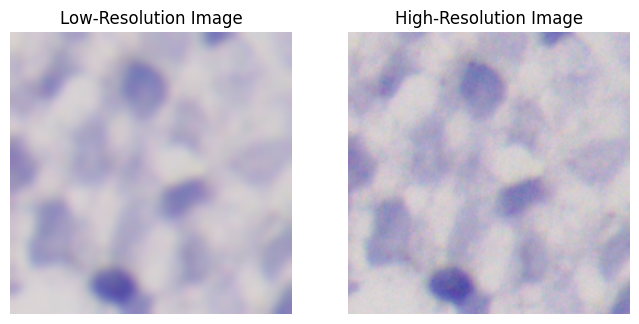

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

axes[0].imshow(train_low_images[10])
axes[0].set_title("Low-Resolution Image")
axes[0].axis("off")

axes[1].imshow(train_high_images[10])
axes[1].set_title("High-Resolution Image")
axes[1].axis("off")

plt.show()

# Model

In [12]:
def down_block(x, filters, kernel_size, apply_batch_normalization=True):
    x = layers.Conv2D(filters, kernel_size, padding="same", strides=2)(x)
    if apply_batch_normalization:
        x = layers.BatchNormalization()(x)

    x = layers.LeakyReLU()(x)
    return x

In [13]:
def up_block(x, skip, filters, kernel_size, dropout=False):
    x = layers.Conv2DTranspose(filters, kernel_size, padding="same", strides=2)(x)
    if dropout:
        x = layers.Dropout(0.1)(x)

    x = layers.LeakyReLU()(x)
    x = layers.concatenate([x, skip])
    return x

In [14]:
def build_model(size):
    inputs = layers.Input(shape=[size, size, 3])

    # Downsampling
    d1 = down_block(inputs, 128, (3, 3), apply_batch_normalization=False)
    d2 = down_block(d1, 128, (3, 3), apply_batch_normalization=False)
    d3 = down_block(d2, 256, (3, 3), apply_batch_normalization=True)
    d4 = down_block(d3, 512, (3, 3), apply_batch_normalization=True)
    d5 = down_block(d4, 512, (3, 3), apply_batch_normalization=True)

    # Upsampling
    u1 = up_block(d5, d4, 512, (3, 3), dropout=False)
    u2 = up_block(u1, d3, 256, (3, 3), dropout=False)
    u3 = up_block(u2, d2, 128, (3, 3), dropout=False)
    u4 = up_block(u3, d1, 128, (3, 3), dropout=False)

    # Final upsampling
    u5 = layers.Conv2DTranspose(3, (3, 3), padding='same', strides=2)(u4)
    u5 = layers.LeakyReLU()(u5)
    u5 = layers.concatenate([u5, inputs])

    # Output layer
    outputs = layers.Conv2D(3, (2, 2), padding='same', strides=1)(u5)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [15]:
model = build_model(size=SIZE)

In [16]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      3,584 │ input_layer[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │    147,584 │ leaky_re_lu[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │    295,168 │ leaky_re_lu_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ leaky_re_lu_2[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 512) │  2,359,808 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,359,808 │ leaky_re_lu_4[0]… │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ leaky_re_lu_5[0]… │
│ (Concatenate)       │ 1024)             │            │ leaky_re_lu_3[0]

 Total params: 9,602,766 (36.63 MB)

 Trainable params: 9,600,206 (36.62 MB)

 Non-trainable params: 2,560 (10.00 KB)

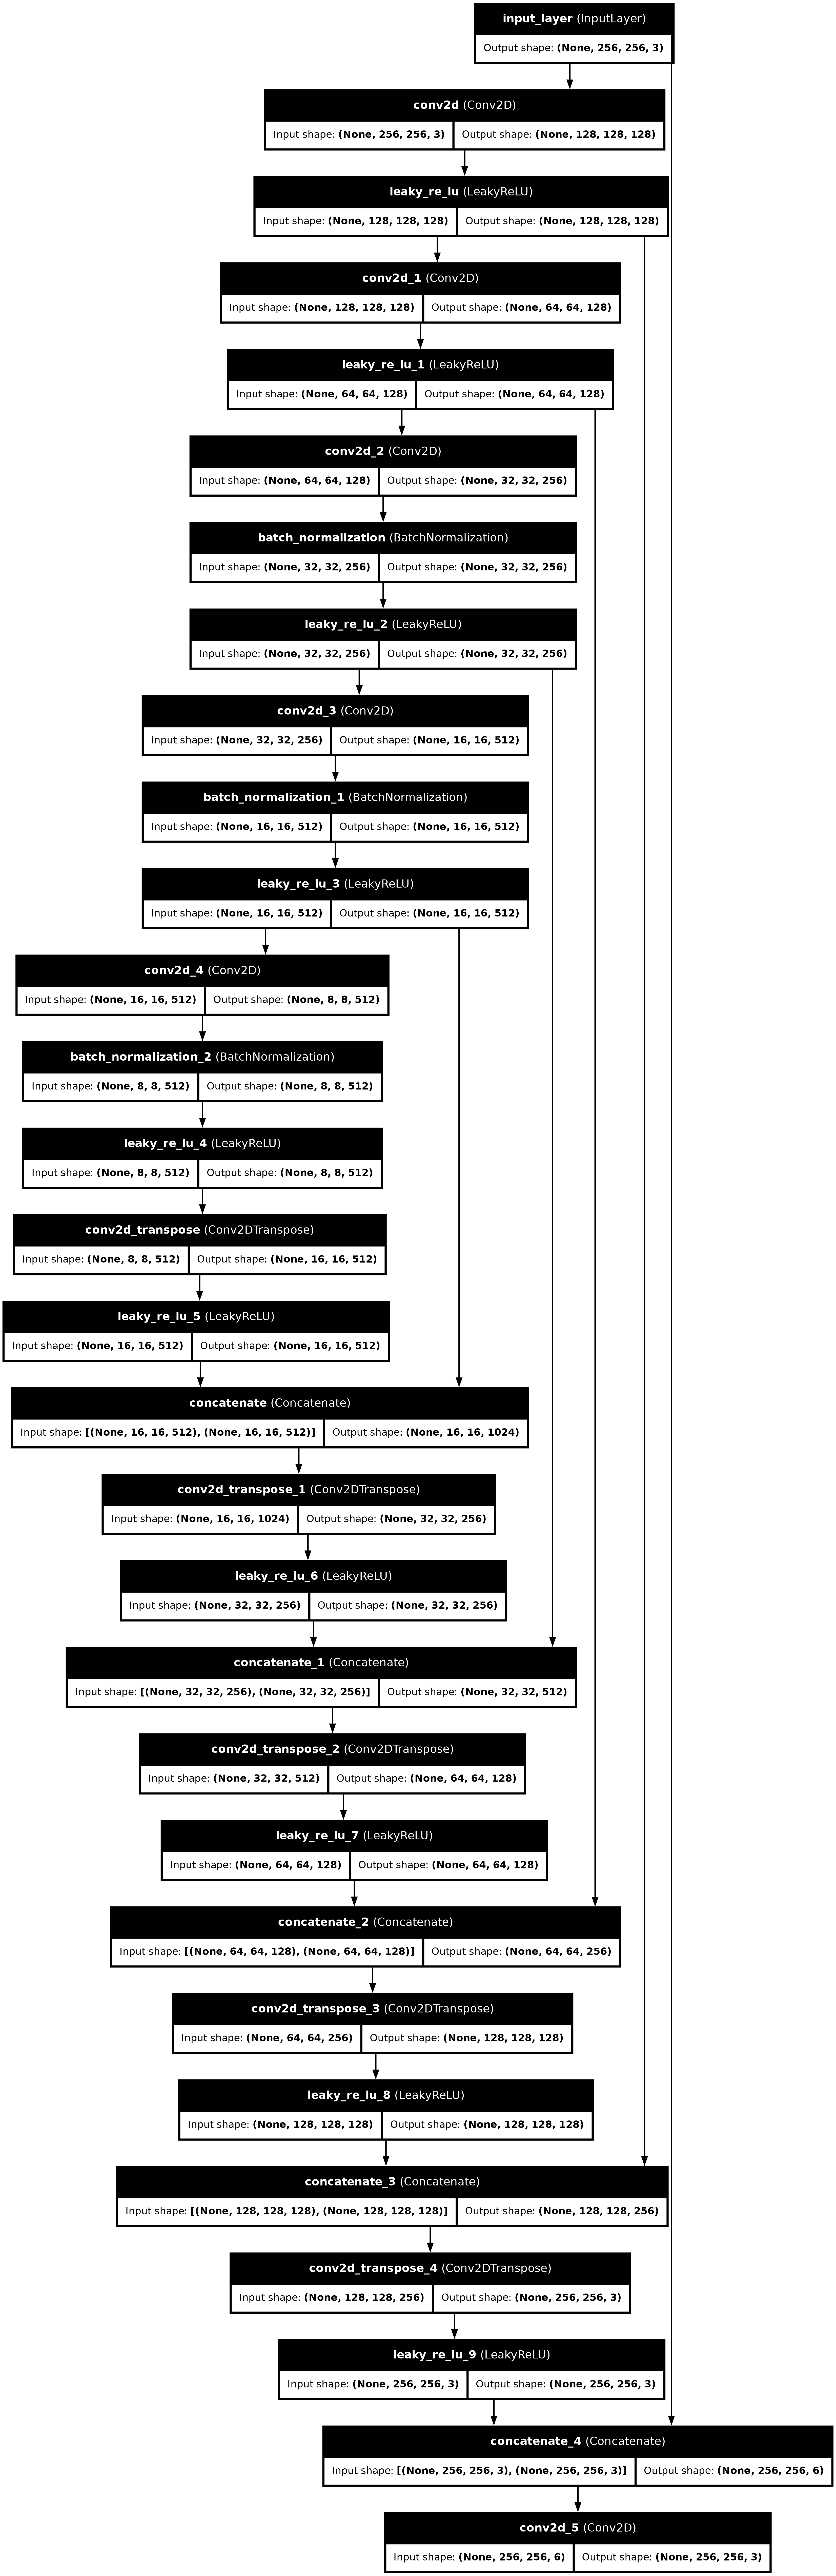

In [17]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [18]:
model.compile(
    optimizer = optimizers.Adam(learning_rate=0.001),
    loss = "mean_absolute_error",
    metrics = ["accuracy"]
)

# Train

In [19]:
history = model.fit(
    train_low_images,
    train_high_images,
    epochs = 200,
    batch_size = 16,
    validation_data=(test_low_images, test_high_images),
    verbose = 1
)

Epoch 1/200


I0000 00:00:1742286045.526815      72 service.cc:145] XLA service 0x7fbdb8008ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742286045.526910      72 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1742286045.526917      72 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1742286062.204097      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.1003 - loss: 0.8065 - val_accuracy: 0.3870 - val_loss: 0.6880
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.3023 - loss: 0.4636 - val_accuracy: 0.3642 - val_loss: 0.4225
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - accuracy: 0.3218 - loss: 0.2425 - val_accuracy: 0.3417 - val_loss: 0.2887
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.3557 - loss: 0.0931 - val_accuracy: 0.2863 - val_loss: 0.1086
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - accuracy: 0.4288 - loss: 0.0520 - val_accuracy: 0.3634 - val_loss: 0.0753
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.5653 - loss: 0.0370 - val_accuracy: 0.2759 - val_loss: 0.0641
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - accuracy: 0.6358 - loss: 0.0325 - val_accuracy: 0.5357 - val_loss: 0.0411
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.6304 - loss: 0.0307 - val_accuracy: 0.5687 -

# Results

In [20]:
history_df = pd.DataFrame(history.history)
history_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.127684,0.722969,0.386986,0.688048
1,0.309271,0.417767,0.364182,0.422476
2,0.342140,0.194943,0.341699,0.288732
3,0.386339,0.081459,0.286268,0.108555
4,0.469061,0.047322,0.363374,0.075280


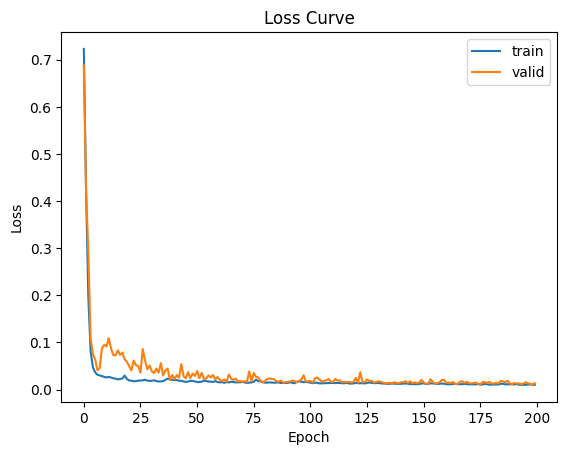

In [21]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend(["train", "valid"])
plt.show()

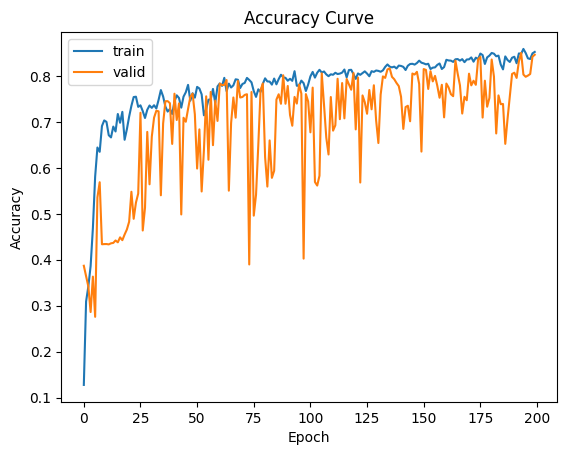

In [22]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend(["train", "valid"])
plt.show()

In [23]:
def predict_images(test_low, test_high, count=5, size=224):
    for _ in range(count):
        random_idx = np.random.randint(len(test_low))
        predicted = model.predict(test_low[random_idx].reshape(1, size, size, 3), verbose=0)
        predicted = np.clip(predicted, 0.0, 1.0).reshape(size, size, 3)
        
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
        
        axes[0].imshow(test_low[random_idx])
        axes[0].set_title("Low-Resolution Image")
        axes[0].axis("off")
        
        axes[1].imshow(test_high[random_idx])
        axes[1].set_title("Ground Truth")
        axes[1].axis("off")

        axes[2].imshow(predicted)
        axes[2].set_title("Enhanced Image")
        axes[2].axis("off")
        
        plt.show()

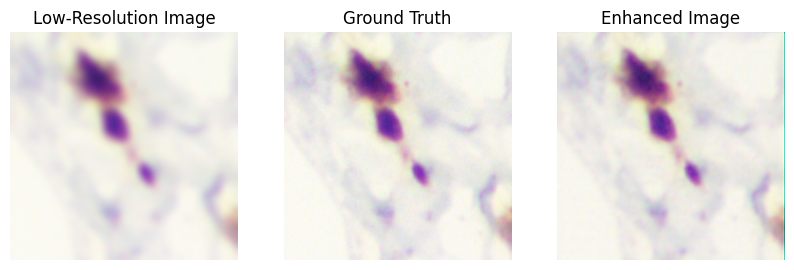

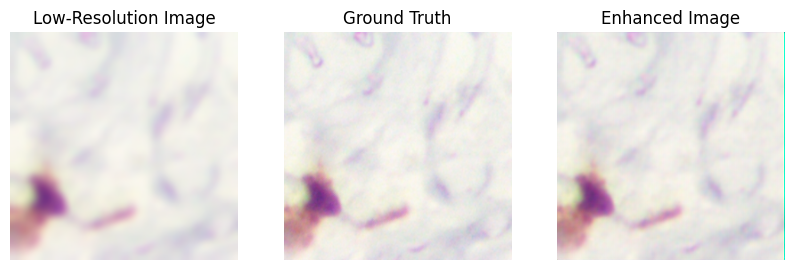

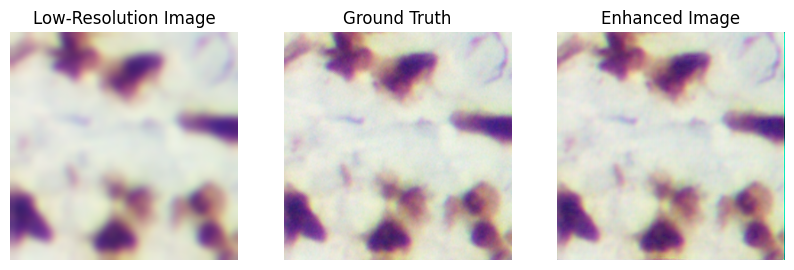

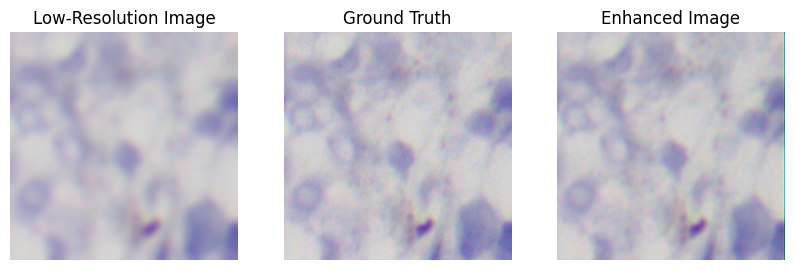

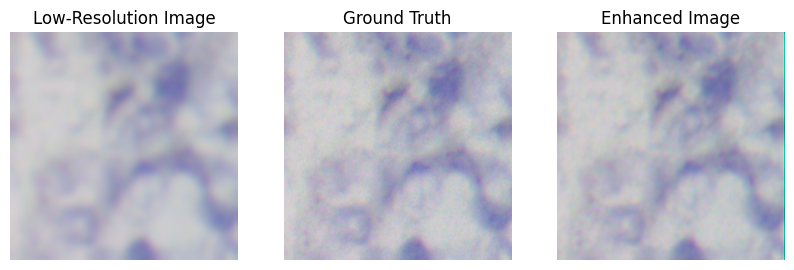

In [24]:
predict_images(test_low_images, test_high_images, count=5, size=SIZE)